<a href="https://colab.research.google.com/github/dungruoc/DeepLearning-Pytorch/blob/main/SpatialTransformerNetworks.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from __future__ import print_function
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import numpy as np

plt.ion()   # interactive mode

In [2]:
# Training dataset
train_loader = torch.utils.data.DataLoader(
    datasets.MNIST(root='./data', train=True, download=True,
                   transform=transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize((0.1307,), (0.3081,))
                   ])), batch_size=64, shuffle=True, num_workers=4)
# Test dataset
test_loader = torch.utils.data.DataLoader(
    datasets.MNIST(root='./data', train=False, transform=transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.1307,), (0.3081,))
    ])), batch_size=64, shuffle=True, num_workers=4)

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:566: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


In [3]:
device = torch.device('cuda')

In [4]:
class View(nn.Module):
    def __init__(self, a, b):
        super().__init__()
        self.a = a
        self.b = b

    def forward(self, x):
        return x.view(self.a, self.b)

class CnnClassifier(nn.Module):
  def __init__(self):
    super().__init__()
    self.model = nn.Sequential(
        nn.Conv2d(1, 10, kernel_size=5),
        nn.MaxPool2d(2, stride=2),
        nn.ReLU(True),
        nn.Conv2d(10, 20, kernel_size=5),
        nn.Dropout2d(),
        nn.MaxPool2d(2, stride=2),
        nn.ReLU(True),
        View(-1, 320),
        nn.Linear(320, 50),
        nn.ReLU(True),
        nn.Dropout1d(),
        nn.Linear(50, 10),
        nn.LogSoftmax(dim=1)
    )

  def forward(self, x):
    return self.model(x)

class STN(nn.Module):
  def __init__(self):
    super().__init__()
    self.localization = nn.Sequential(
        nn.Conv2d(1, 8, kernel_size=7),
        nn.MaxPool2d(2, stride=2),
        nn.ReLU(True),
        nn.Conv2d(8, 10, kernel_size=5),
        nn.MaxPool2d(2, stride=2),
        nn.ReLU(True)
    )
    
    self.fc_loc = nn.Sequential(
        nn.Linear(10 * 3 * 3, 32),
        nn.ReLU(True),
        nn.Linear(32, 3 * 2)
    )
    
    self.fc_loc[2].weight.data.zero_()
    self.fc_loc[2].bias.data.copy_(torch.tensor([1, 0, 0, 0, 1, 0]))
  
  def forward(self, x):
    xs = self.localization(x)
    xs = xs.view(-1, 10 * 3 * 3)
    theta = self.fc_loc(xs)
    theta = theta.view(-1, 2, 3)
    
    grid = F.affine_grid(theta, x.size())
    return F.grid_sample(x, grid)

In [6]:
def train(epoch, model, optimizer, device):
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)

        optimizer.zero_grad()
        output = model(data)
        loss = F.nll_loss(output, target)
        loss.backward()
        optimizer.step()
        if batch_idx % 500 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))
#
# A simple test procedure to measure the STN performances on MNIST.
#

def test(model, device):
    with torch.no_grad():
        model.eval()
        test_loss = 0
        correct = 0
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)

            # sum up batch loss
            test_loss += F.nll_loss(output, target, size_average=False).item()
            # get the index of the max log-probability
            pred = output.max(1, keepdim=True)[1]
            correct += pred.eq(target.view_as(pred)).sum().item()

        test_loss /= len(test_loader.dataset)
        print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'
              .format(test_loss, correct, len(test_loader.dataset),
                      100. * correct / len(test_loader.dataset)))

In [7]:
cnn_classifier = CnnClassifier().to(device)
optimizer = optim.SGD(cnn_classifier.parameters(), lr=0.01)

In [8]:
for epoch in range(1, 20 + 1):
    train(epoch, cnn_classifier, optimizer, device)
    test(cnn_classifier, device)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:566: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Train Epoch: 1 [0/60000 (0%)]	Loss: 2.314092
Train Epoch: 1 [32000/60000 (53%)]	Loss: 1.400822


/usr/local/lib/python3.7/dist-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))



Test set: Average loss: 0.4217, Accuracy: 9222/10000 (92%)

Train Epoch: 2 [0/60000 (0%)]	Loss: 1.165354
Train Epoch: 2 [32000/60000 (53%)]	Loss: 1.216259

Test set: Average loss: 0.2940, Accuracy: 9505/10000 (95%)

Train Epoch: 3 [0/60000 (0%)]	Loss: 1.423835
Train Epoch: 3 [32000/60000 (53%)]	Loss: 1.492826

Test set: Average loss: 0.2367, Accuracy: 9560/10000 (96%)

Train Epoch: 4 [0/60000 (0%)]	Loss: 1.308500
Train Epoch: 4 [32000/60000 (53%)]	Loss: 1.274935

Test set: Average loss: 0.2097, Accuracy: 9654/10000 (97%)

Train Epoch: 5 [0/60000 (0%)]	Loss: 1.294281
Train Epoch: 5 [32000/60000 (53%)]	Loss: 1.074723

Test set: Average loss: 0.1808, Accuracy: 9713/10000 (97%)

Train Epoch: 6 [0/60000 (0%)]	Loss: 1.251022
Train Epoch: 6 [32000/60000 (53%)]	Loss: 1.317689

Test set: Average loss: 0.1696, Accuracy: 9741/10000 (97%)

Train Epoch: 7 [0/60000 (0%)]	Loss: 1.194698
Train Epoch: 7 [32000/60000 (53%)]	Loss: 1.467805

Test set: Average loss: 0.1543, Accuracy: 9741/10000 (97%)

Tra

In [10]:
import copy
cnn_state = copy.deepcopy(cnn_classifier.state_dict())

stn_model = nn.Sequential(
    STN(),
    CnnClassifier()
)

stn_model[1].load_state_dict(cnn_state)
for param in stn_model[1].parameters():
    param.requires_grad = False

stn_model = stn_model.to(device)

In [11]:
optimizer = optim.SGD(stn_model.parameters(), lr=0.01)
for epoch in range(1, 20 + 1):
    train(epoch, stn_model, optimizer, device)
    test(stn_model, device)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:566: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:4278: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  "Default grid_sample and affine_grid behavior has changed "
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:4216: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify ali

Train Epoch: 1 [0/60000 (0%)]	Loss: 1.319789
Train Epoch: 1 [32000/60000 (53%)]	Loss: 0.965844


/usr/local/lib/python3.7/dist-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))



Test set: Average loss: 0.0931, Accuracy: 9863/10000 (99%)

Train Epoch: 2 [0/60000 (0%)]	Loss: 1.304262
Train Epoch: 2 [32000/60000 (53%)]	Loss: 1.310780

Test set: Average loss: 0.0933, Accuracy: 9859/10000 (99%)

Train Epoch: 3 [0/60000 (0%)]	Loss: 1.055511
Train Epoch: 3 [32000/60000 (53%)]	Loss: 1.130374

Test set: Average loss: 0.0930, Accuracy: 9867/10000 (99%)

Train Epoch: 4 [0/60000 (0%)]	Loss: 1.332148
Train Epoch: 4 [32000/60000 (53%)]	Loss: 1.173909

Test set: Average loss: 0.0934, Accuracy: 9873/10000 (99%)

Train Epoch: 5 [0/60000 (0%)]	Loss: 1.249683
Train Epoch: 5 [32000/60000 (53%)]	Loss: 1.196138

Test set: Average loss: 0.1148, Accuracy: 9802/10000 (98%)

Train Epoch: 6 [0/60000 (0%)]	Loss: 0.966438
Train Epoch: 6 [32000/60000 (53%)]	Loss: 1.086290

Test set: Average loss: 0.0929, Accuracy: 9878/10000 (99%)

Train Epoch: 7 [0/60000 (0%)]	Loss: 1.186240
Train Epoch: 7 [32000/60000 (53%)]	Loss: 1.233943

Test set: Average loss: 0.0918, Accuracy: 9863/10000 (99%)

Tra

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:566: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:4278: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  "Default grid_sample and affine_grid behavior has changed "
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:4216: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify ali

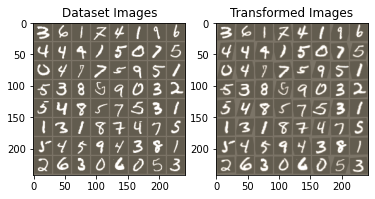

In [12]:
def convert_image_np(inp):
    """Convert a Tensor to numpy image."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    return inp

# We want to visualize the output of the spatial transformers layer
# after the training, we visualize a batch of input images and
# the corresponding transformed batch using STN.


def visualize_stn(stn_model):
    with torch.no_grad():
        # Get a batch of training data
        data = next(iter(test_loader))[0].to(device)

        input_tensor = data.cpu()
        transformed_input_tensor = stn_model(data).cpu()

        in_grid = convert_image_np(
            torchvision.utils.make_grid(input_tensor))

        out_grid = convert_image_np(
            torchvision.utils.make_grid(transformed_input_tensor))

        # Plot the results side-by-side
        f, axarr = plt.subplots(1, 2)
        axarr[0].imshow(in_grid)
        axarr[0].set_title('Dataset Images')

        axarr[1].imshow(out_grid)
        axarr[1].set_title('Transformed Images')


# Visualize the STN transformation on some input batch
visualize_stn(stn_model[0])

plt.ioff()
plt.show()

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:566: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:4278: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  "Default grid_sample and affine_grid behavior has changed "
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:4216: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify ali

Train Epoch: 1 [0/60000 (0%)]	Loss: 2.296935
Train Epoch: 1 [32000/60000 (53%)]	Loss: 1.527016


/usr/local/lib/python3.7/dist-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))



Test set: Average loss: 0.3764, Accuracy: 9382/10000 (94%)

Train Epoch: 2 [0/60000 (0%)]	Loss: 1.442392
Train Epoch: 2 [32000/60000 (53%)]	Loss: 1.200036

Test set: Average loss: 0.2130, Accuracy: 9630/10000 (96%)

Train Epoch: 3 [0/60000 (0%)]	Loss: 1.060524
Train Epoch: 3 [32000/60000 (53%)]	Loss: 1.228267

Test set: Average loss: 0.1583, Accuracy: 9711/10000 (97%)

Train Epoch: 4 [0/60000 (0%)]	Loss: 1.310020
Train Epoch: 4 [32000/60000 (53%)]	Loss: 1.190470

Test set: Average loss: 0.1322, Accuracy: 9761/10000 (98%)

Train Epoch: 5 [0/60000 (0%)]	Loss: 1.273374
Train Epoch: 5 [32000/60000 (53%)]	Loss: 1.137825

Test set: Average loss: 0.1628, Accuracy: 9711/10000 (97%)

Train Epoch: 6 [0/60000 (0%)]	Loss: 1.185097
Train Epoch: 6 [32000/60000 (53%)]	Loss: 1.077494

Test set: Average loss: 0.1105, Accuracy: 9810/10000 (98%)

Train Epoch: 7 [0/60000 (0%)]	Loss: 1.171995
Train Epoch: 7 [32000/60000 (53%)]	Loss: 1.345453

Test set: Average loss: 0.1124, Accuracy: 9795/10000 (98%)

Tra

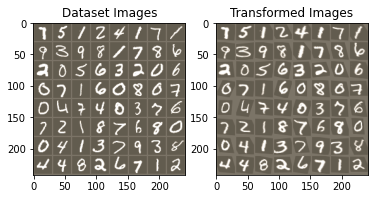

In [13]:
stn_model2 = nn.Sequential(
    STN(),
    CnnClassifier()
)

stn_model2 = stn_model2.to(device)

optimizer = optim.SGD(stn_model2.parameters(), lr=0.01)
for epoch in range(1, 40 + 1):
    train(epoch, stn_model2, optimizer, device)
    test(stn_model2, device)

visualize_stn(stn_model2[0])

plt.ioff()
plt.show()